# I. Overview and Workflow

## A. Introduction

This Jupyter Notebook provides an end-to-end analysis of Switzerland’s energy data, focusing on load forecasting and time series diagnostics. It is designed for clarity and reproducibility, with each section logically organized and annotated.

### Navigation
- The notebook is divided into sections using markdown headers (e.g., data loading, preprocessing, modeling, diagnostics).
- Code blocks are accompanied by comments for clarity.

### Purpose
The notebook aims to:
- Understand the seasonal and stochastic properties of the Swiss power grid data.
- Fit and compare ARIMA, SARIMA, and SARIMAX models.
- Evaluate model adequacy through residual diagnostics and choose the best model through MAPE.

## B. Energy Data Retrieval

### Data Sources
- **Swissgrid operational data**: Weekly records of energy consumption, production, control energy, and prices.
- **ECMWF seasonal forecasts**: Monthly ensemble mean temperature data aggregated over Switzerland, used as a covariate for SARIMAX modeling.

**0. Installing Dependencies**

In [62]:
#Dependencies
%pip install openpyxl matplotlib pandas darts statsmodels -q
#Dependencies for weather data
%pip install xarray cfgrib eccodes -q

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [63]:
file_paths = [
    '../Archive/Data/EnergieUebersichtCH-2022.xlsx',
    '../Archive/Data/EnergieUebersichtCH-2023.xlsx',
    '../Archive/Data/EnergieUebersichtCH-2024.xlsx',
    '../Archive/Data/EnergieUebersichtCH-2025.xlsx',
]
sheet_name = 'Zeitreihen0h15'
total = 29000

**1.1 Retrieving Energy Data**

In [64]:
import pandas as pd

In [65]:
if 'dfs_loaded' not in globals():
    dfs = []
    for path in file_paths:
        xls = pd.ExcelFile(path)
        df_year = pd.read_excel(xls, sheet_name=sheet_name, header=1)
        dfs.append(df_year)
    dfs_loaded = True 


**1.2 Combining all years into a single DataFrame and rename columns**

In [66]:
df = pd.concat(dfs, ignore_index=True)
column_mapping = { 
    'kWh': 'Total Energy Consumed by End Users (kWh)',
    'kWh.1': 'Total Energy Production (kWh)',
    'kWh.2': 'Total Energy Consumption (kWh)',
    'kWh.3': 'Net Outflow (kWh)',
    'kWh.4': 'Grid Feed-In (kWh)',
    'kWh.5': 'Positive Secondary Control Energy (kWh)',
    'kWh.6': 'Negative Secondary Control Energy (kWh)',
    'kWh.7': 'Positive Tertiary Control Energy (kWh)',
    'kWh.8': 'Negative Tertiary Control Energy (kWh)',
    'kWh.11': 'Secondary Control Energy Prices (€/MWh)' 
}

df.rename(columns=column_mapping, inplace=True)

## D. Data Cleaning

Checking for missing values

In [67]:
import plotly.express as px

df.loc[df['Total Energy Consumption (kWh)'].isna(), 'color'] = 'Total Energy Consumption'

# Mask for rows with any NA values
mask = df.isna().any(axis=1)
df_missing = df[mask].copy()
df_missing['is_missing'] = True  # optional for consistent y-axis

print(df_missing.head())


Empty DataFrame
Columns: [Zeitstempel, Total Energy Consumed by End Users (kWh), Total Energy Production (kWh), Total Energy Consumption (kWh), Net Outflow (kWh), Grid Feed-In (kWh), Positive Secondary Control Energy (kWh), Negative Secondary Control Energy (kWh), Positive Tertiary Control Energy (kWh), Negative Tertiary Control Energy (kWh), kWh.9, kWh.10, Secondary Control Energy Prices (€/MWh), kWh.12, kWh.13, kWh.14, kWh.15, kWh.16, kWh.17, kWh.18, kWh.19, Euro/MWh, Euro/MWh.1, Euro/MWh.2, Euro/MWh.3, kWh.20, kWh.21, kWh.22, kWh.23, kWh.24, kWh.25, kWh.26, kWh.27, kWh.28, kWh.29, kWh.30, kWh.31, kWh.32, kWh.33, kWh.34, kWh.35, kWh.36, kWh.37, kWh.38, kWh.39, kWh.40, kWh.41, kWh.42, kWh.43, kWh.44, kWh.45, kWh.46, kWh.47, kWh.48, kWh.49, kWh.50, kWh.51, kWh.52, kWh.53, kWh.54, kWh.55, kWh.56, kWh.57, kWh.58, kWh.59, color, is_missing]
Index: []

[0 rows x 67 columns]


Is each index unique?

In [68]:
df.index.is_unique

True

Check min, max, std for anomalies

In [69]:
print(df['Total Energy Consumption (kWh)'].describe()[1:9]) 

mean    1.803166e+06
std     2.656051e+05
min     1.038507e+06
25%     1.626075e+06
50%     1.808781e+06
75%     1.983396e+06
max     2.603810e+06
Name: Total Energy Consumption (kWh), dtype: float64


## E. Data Aggregation

1.1 Aggregate Data by week, starting Monday, drop incomplete sums, backup df

In [70]:
df['Zeitstempel'] = pd.to_datetime(
    df['Zeitstempel'],
    format='%d.%m.%Y %H:%M',   
    dayfirst=True,            
    errors='raise'            
)

df = df.set_index('Zeitstempel')
df = df.resample('W-Mon').sum()
df = df[1:-1]
df_backup = df
energy_consumption_data = df['Total Energy Consumption (kWh)'].copy()

## C. Weather Data Retrieval 

In [71]:
time_index = df.index

In [72]:
import cdsapi
import xarray as xr
import pandas as pd

c = cdsapi.Client()
lat_min = 45.8
lat_max = 48.5
lon_min = 5.9
lon_max = 10.5

# Load and combine datasets once
if 'weather_loaded' not in globals():
    ds_before_2025 = xr.open_dataset(
        "../Archive/Data/Weather/Seasonal forecast monthly statistics on single levels - CH- 2021-2024.grib",
        engine="cfgrib"
    )
    ds_2025 = xr.open_dataset(
        "../Archive/Data/Weather/Seasonal forecast monthly statistics on single levels - CH- 2025.grib",
        engine="cfgrib"
    )

    ds = xr.concat([ds_before_2025, ds_2025], dim="time")
    swiss = ds['t2m'].sel(
        latitude=slice(48.5, 45.8),
        longitude=slice(5.9, 10.5)
    )
    weather_loaded = True

# Step 1: Average over spatial and ensemble dimensions
monthly_avg = swiss.mean(dim=['latitude', 'longitude', 'number'])
monthly_mean = monthly_avg.mean(dim='step')  # Mean over lead times

# Step 2: Convert to pandas Series and round index to start of month
monthly_series = monthly_mean.to_series()
monthly_series.index = monthly_series.index.to_period("M").to_timestamp()

# Step 3: Filter out data before 2022
monthly_series = monthly_series[monthly_series.index >= pd.Timestamp("2022-01-01")]

# Step 4: Map each weekly point to its corresponding monthly temperature
assert isinstance(time_index, pd.DatetimeIndex)

weekly_temp = pd.Series(
    index=time_index,
    data=[monthly_series.get(dt.to_period("M").to_timestamp(), pd.NA) for dt in time_index]
)

weekly_temp = weekly_temp.dropna()

# Optional: enforce datetime index and infer frequency
weekly_temp.index = pd.DatetimeIndex(weekly_temp.index)
try:
    weekly_temp.index.freq = pd.infer_freq(weekly_temp.index)
except:
    pass

# Preview
print(weekly_temp.head())

Zeitstempel
2022-01-10    272.436157
2022-01-17    272.436157
2022-01-24    272.436157
2022-01-31    272.436157
2022-02-07    275.031769
Freq: W-MON, dtype: float32


# II. Visualisation

## A. Total Consumption

In [73]:
import matplotlib.pyplot as plt

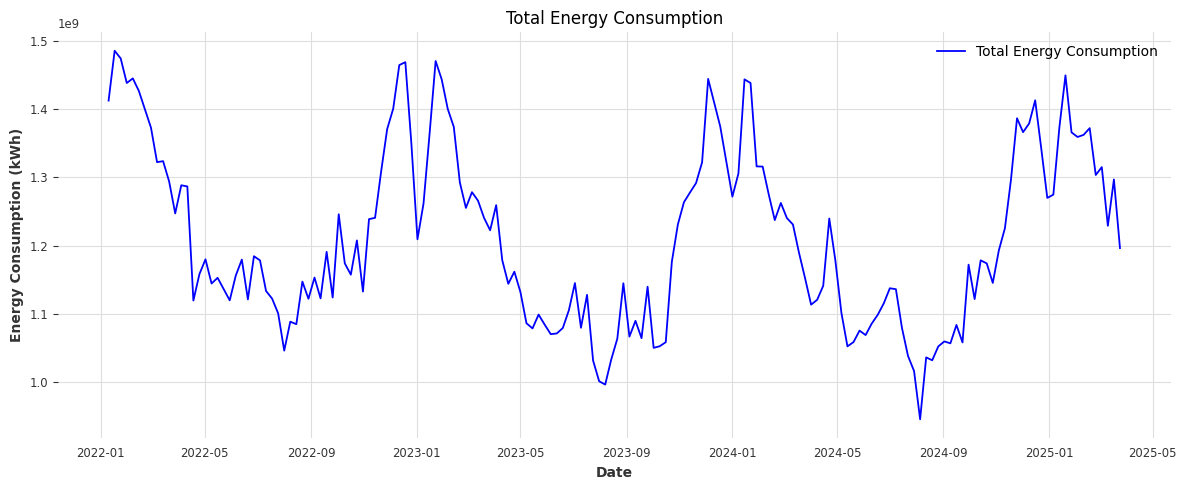

In [74]:
fig, ax = plt.subplots(figsize=(12, 5))
ax.plot(df['Total Energy Consumption (kWh)'], label='Total Energy Consumption', color='blue')
ax.set_title('Total Energy Consumption')
ax.set_xlabel('Date')
ax.set_ylabel('Energy Consumption (kWh)')
ax.legend()
ax.grid(True)
plt.tight_layout()
plt.show()

## B. Total Consumption by year

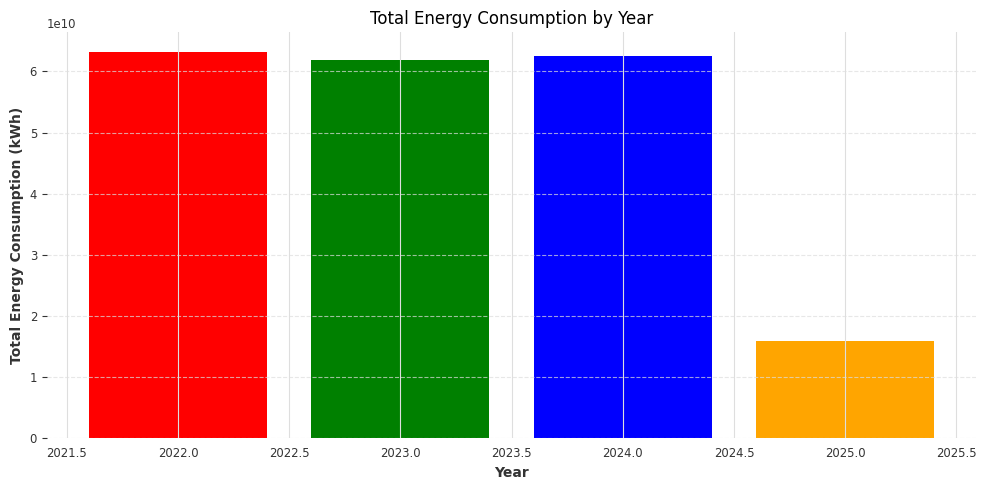

In [75]:
# Chart: Total Energy Consumption by Year (Aggregated with different bar colors)
import matplotlib.pyplot as plt

yearly_consumption = df['Total Energy Consumption (kWh)'].resample('Y').sum()

colors = ['red', 'green', 'blue', 'orange', 'purple', 'cyan']

fig, ax = plt.subplots(figsize=(10, 5))
ax.bar(yearly_consumption.index.year, yearly_consumption.values, color=colors[:len(yearly_consumption)])

ax.set_title('Total Energy Consumption by Year')
ax.set_xlabel('Year')
ax.set_ylabel('Total Energy Consumption (kWh)')
ax.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


## C. Total Consumption by month

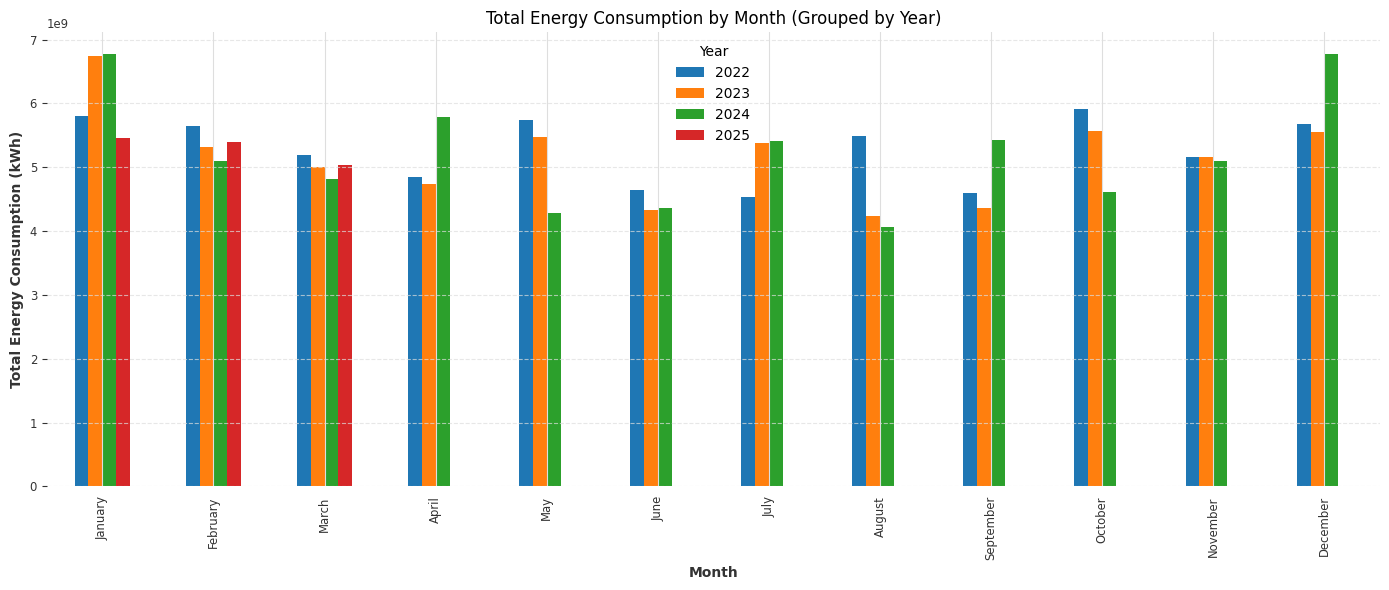

In [76]:
import pandas as pd
import matplotlib.pyplot as plt

monthly_consumption = df['Total Energy Consumption (kWh)'].resample('M').sum()

monthly_df = monthly_consumption.to_frame()
monthly_df['Year'] = monthly_df.index.year
monthly_df['Month'] = monthly_df.index.month_name()

pivot = monthly_df.pivot_table(
    index='Month',
    columns='Year',
    values='Total Energy Consumption (kWh)',
    aggfunc='sum'
)

month_order = [
    'January', 'February', 'March', 'April', 'May', 'June',
    'July', 'August', 'September', 'October', 'November', 'December'
]
pivot = pivot.reindex(month_order)

# Plot grouped bar chart
pivot.plot(kind='bar', figsize=(14, 6), color=plt.cm.tab10.colors[:len(pivot.columns)])

plt.title('Total Energy Consumption by Month (Grouped by Year)')
plt.xlabel('Month')
plt.ylabel('Total Energy Consumption (kWh)')
plt.legend(title='Year')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


## D. Grid Feed-In

The total of the vertical in feed into the Swiss Transmission grid is the sum of all time series of production metering points and other in feeds over transformers and lines into the transmission grid.

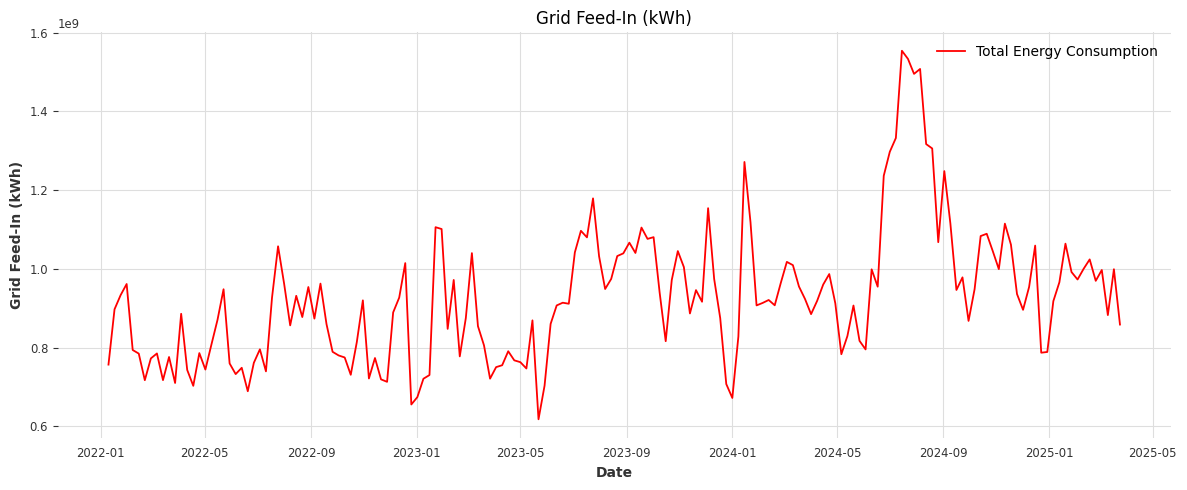

In [77]:
fig, ax = plt.subplots(figsize=(12, 5))
df = df.resample('7D').sum()
ax.plot(df['Grid Feed-In (kWh)'], label='Total Energy Consumption', color='red')
ax.set_title('Grid Feed-In (kWh)')
ax.set_xlabel('Date')
ax.set_ylabel('Grid Feed-In (kWh)')
ax.legend()
ax.grid(True)
plt.tight_layout()
plt.show()

## E. Secondary Control Energy Prices (€/MWh)

These prices represent the cost per megawatt-hour (MWh) for activating secondary control (also called automatic frequency restoration reserve, aFRR) in the Swiss power grid.
Secondary control energy is used to balance short-term fluctuations between electricity supply and demand, maintaining grid frequency close to its nominal value (e.g., 50 Hz).
The price reflects the market cost for procuring this balancing service from providers, and is typically determined through auctions or market mechanisms operated by Swissgrid.

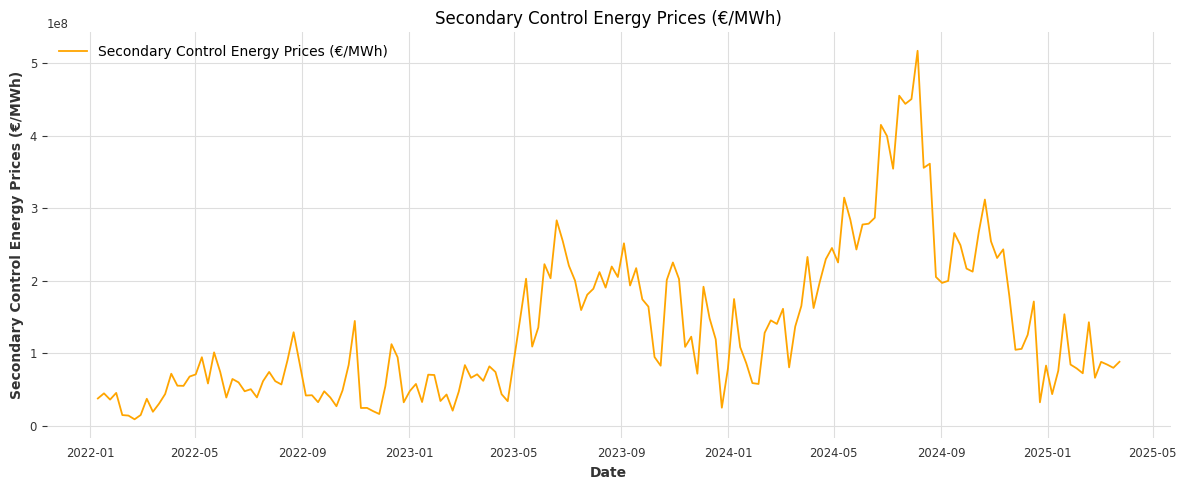

In [78]:
fig, ax = plt.subplots(figsize=(12, 5))
ax.plot(df['Secondary Control Energy Prices (€/MWh)'], label='Secondary Control Energy Prices (€/MWh)', color='orange')
ax.set_title('Secondary Control Energy Prices (€/MWh)')
ax.set_xlabel('Date')
ax.set_ylabel('Secondary Control Energy Prices (€/MWh)')
ax.legend()
ax.grid(True)
plt.tight_layout()
plt.show()

## F. Visualising Weather 

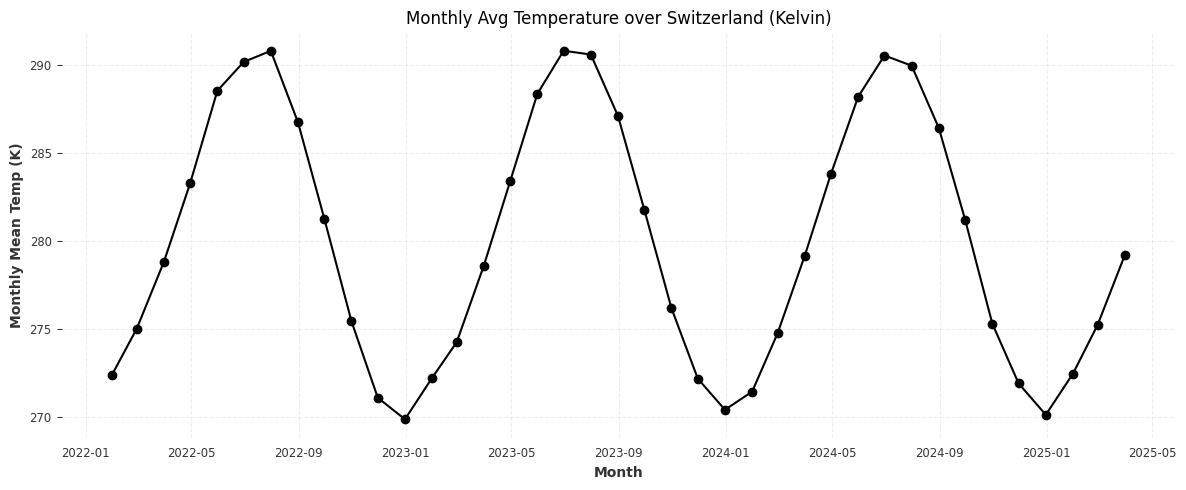

In [79]:

# Ensure proper formatting
assert isinstance(weekly_temp, pd.Series)
weekly_temp = weekly_temp.dropna()
weekly_temp.index = pd.to_datetime(weekly_temp.index)

# Aggregate to monthly mean temperature
monthly_temp = weekly_temp.resample("M").mean()

# Plot as line chart
plt.figure(figsize=(12, 5))
plt.plot(monthly_temp.index, monthly_temp.values, marker='o', linestyle='-', linewidth=1.5)

plt.title("Monthly Avg Temperature over Switzerland (Kelvin)")
plt.xlabel("Month")
plt.ylabel("Monthly Mean Temp (K)")
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

# III. Data Correlation

## Energy Prices Data correlation

In [80]:
df = df_backup

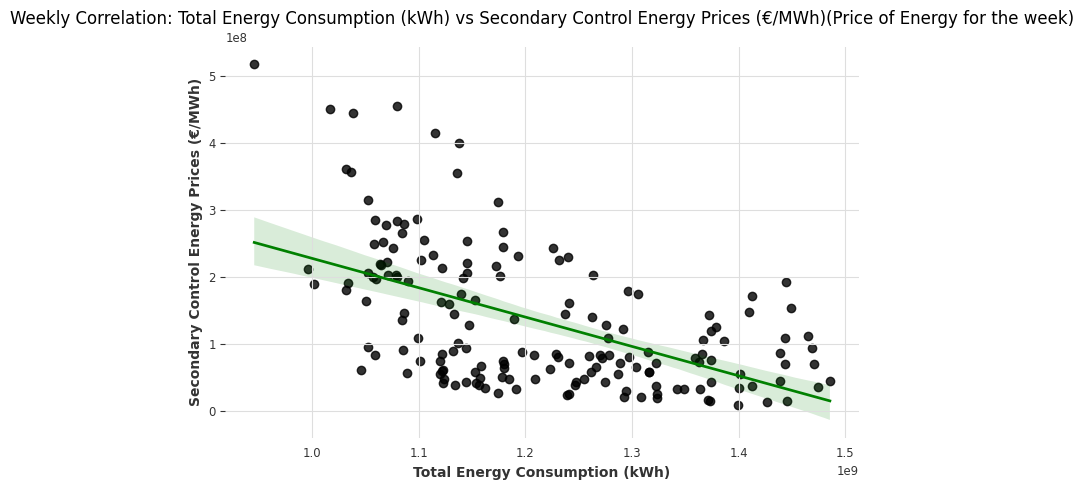

Pearson correlation: -0.5427


In [81]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

x_col = "Total Energy Consumption (kWh)"
y_col = "Secondary Control Energy Prices (€/MWh)"

# Align on weekly frequency and drop missing values
df_weekly = df[[x_col, y_col]].dropna()

# Plot
plt.figure(figsize=(7, 5))
sns.regplot(data=df_weekly, x=x_col, y=y_col, line_kws={"color": "green"})
plt.title(f"Weekly Correlation: {x_col} vs {y_col}(Price of Energy for the week)")
plt.xlabel(x_col)
plt.ylabel(y_col)
plt.grid(True)
plt.tight_layout()
plt.show()

# Pearson correlation
correlation = df_weekly.corr().loc[y_col, x_col]
print(f"Pearson correlation: {correlation:.4f}")


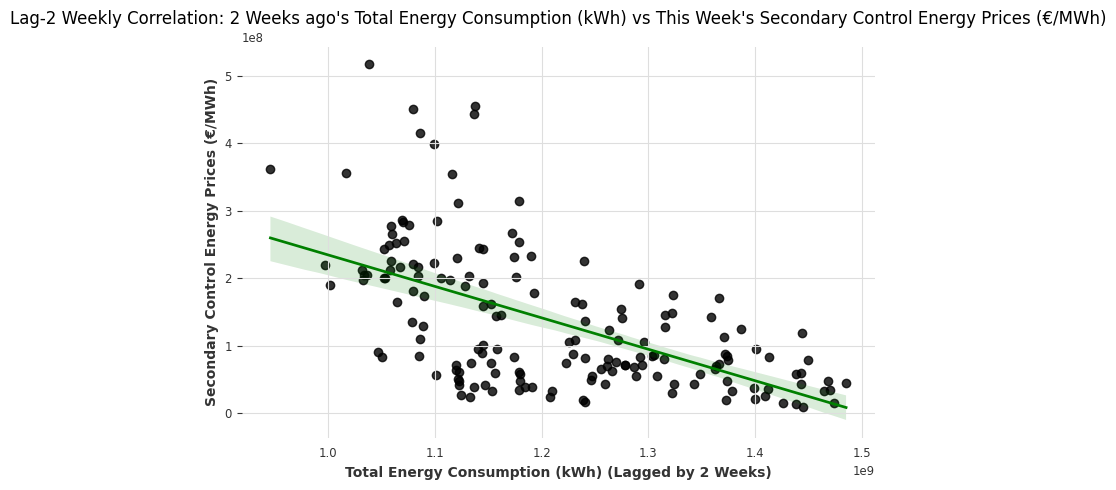

Lag-2 Pearson correlation: -0.5794


In [82]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

x_col = "Total Energy Consumption (kWh)"
y_col = "Secondary Control Energy Prices (€/MWh)"

# Shift consumption by 1 week to see delayed effect
df_shifted = df[[x_col, y_col]].copy()
df_shifted[x_col] = df_shifted[x_col].shift(2)
df_shifted = df_shifted.dropna()

# Plot
plt.figure(figsize=(7, 5))
sns.regplot(data=df_shifted, x=x_col, y=y_col, line_kws={"color": "green"})
plt.title(f"Lag-2 Weekly Correlation: 2 Weeks ago's {x_col} vs This Week's {y_col}")
plt.xlabel(f"{x_col} (Lagged by 2 Weeks)")
plt.ylabel(y_col)
plt.grid(True)
plt.tight_layout()
plt.show()

# Pearson correlation
correlation = df_shifted.corr().loc[y_col, x_col]
print(f"Lag-2 Pearson correlation: {correlation:.4f}")


## Weather Data correlation

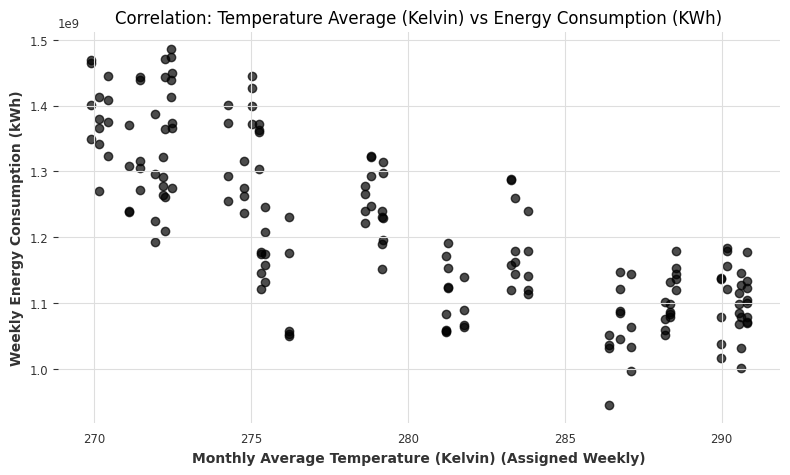

Correlation coefficient: -0.777


In [83]:
temp_series = pd.Series(weekly_temp.values, index=pd.DatetimeIndex(weekly_temp.index))
energy_series = pd.Series(energy_consumption_data, index=pd.DatetimeIndex(time_index))

# Step 2: Align to common date range
common_start = max(temp_series.index.min(), energy_series.index.min())
common_end = min(temp_series.index.max(), energy_series.index.max())

temp_series = temp_series.loc[common_start:common_end]
energy_series = energy_series.loc[common_start:common_end]

# Step 3: Align lengths to prevent mismatches
min_len = min(len(temp_series), len(energy_series))
temp_series = temp_series.iloc[:min_len]
energy_series = energy_series.iloc[:min_len]

# Step 4: Plot correlation scatter
plt.figure(figsize=(8, 5))
plt.scatter(temp_series, energy_series, alpha=0.7)
plt.xlabel("Monthly Average Temperature (Kelvin) (Assigned Weekly)")
plt.ylabel("Weekly Energy Consumption (kWh)")
plt.title("Correlation: Temperature Average (Kelvin) vs Energy Consumption (KWh)")
plt.grid(True)
plt.tight_layout()
plt.show()

# Step 5: Compute and display correlation coefficient
corr_coef = temp_series.corr(energy_series)
print(f"Correlation coefficient: {corr_coef:.3f}")


## Other Data correlation

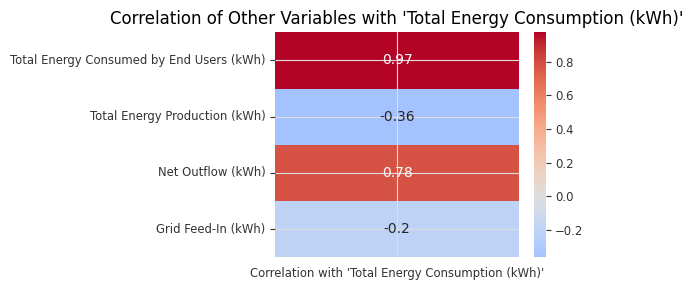

In [84]:
df.index = pd.DatetimeIndex(time_index[:len(df)])

# Step 2: Select the first 5 numeric variables and Total Energy Consumption
selected_cols = df.select_dtypes(include='number').columns[:5].tolist()

# Ensure 'Total Energy Consumption (kWh)' is included
reference_col = "Total Energy Consumption (kWh)"
if reference_col not in selected_cols:
    selected_cols.append(reference_col)

# Step 3: Filter and drop NaNs
df_subset = df[selected_cols].dropna()

# Step 4: Compute correlation with the reference column
correlation_vector = df_subset.corr()[reference_col].drop(reference_col)
correlation_df = correlation_vector.to_frame(name=f"Correlation with '{reference_col}'")

# Step 5: Plot heatmap without white gridlines
plt.figure(figsize=(6, len(correlation_df) * 0.5 + 1))
sns.heatmap(
    correlation_df,
    annot=True,
    cmap="coolwarm",
    center=0,
    cbar=True,
    linewidths=0  # No white lines between cells
)
plt.title(f"Correlation of Other Variables with '{reference_col}'")
plt.tight_layout()
plt.show()


# III: Time Series Analysis 

## A. Mean Calculation

Calculating the mean of my time series (Total Power Consumption in the Grid)

the formula for the mean is: μ = (x₁ + x₂ + ... + xₙ) / n

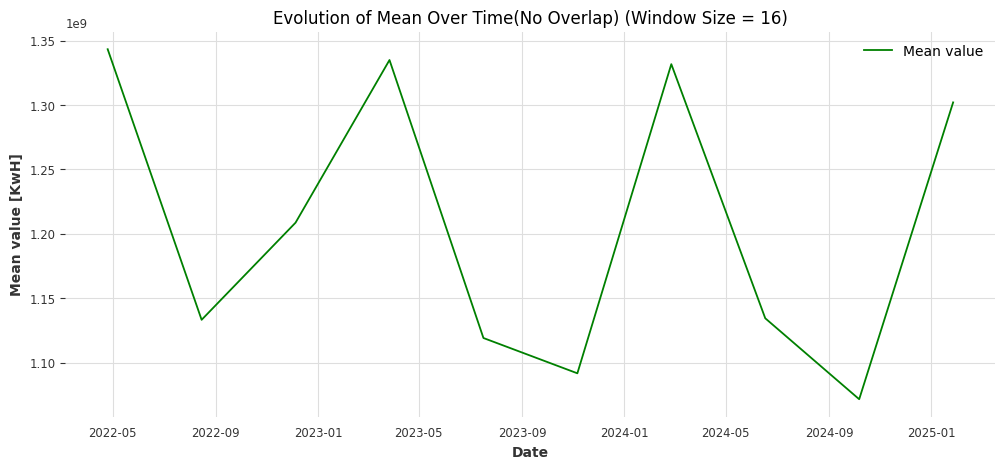

In [85]:
def mean(data):
    return sum(data) / len(data)
def sliced_mean_calculator(data, time_index,variance_window_size):
    means = []
    time_indices = []
    
    for i in range(0, len(data) - variance_window_size + 1, variance_window_size):  
        window_slice = data[i:i + variance_window_size]
        var = mean(window_slice)
        means.append(var)
        time_indices.append(time_index[i + variance_window_size - 1])
    return means, time_indices
mean_window_size = len(energy_consumption_data) // 10
means, time_indices = sliced_mean_calculator(energy_consumption_data,time_index, mean_window_size)
plt.figure(figsize=(12, 5))
plt.plot(time_indices, means, color='green', label='Mean value')
plt.xlabel('Date')
plt.ylabel('Mean value [KwH]')
plt.title(f'Evolution of Mean Over Time(No Overlap) (Window Size = {mean_window_size})')
plt.grid(True)
plt.legend()
plt.show()

## B. Variance Calculation

Calculating Variance:

Variance = 1/n sum(xi- mean)**2

16
[1.0960480879829592e+16, 1464521258618045.5, 7200982635238046.0, 8155543075894944.0, 2430623248220715.5, 5744999445593979.0, 4415194650633357.5, 3907984911992913.0, 2938256858112266.0, 8608203570732048.0] [Timestamp('2022-04-25 00:00:00'), Timestamp('2022-08-15 00:00:00'), Timestamp('2022-12-05 00:00:00'), Timestamp('2023-03-27 00:00:00'), Timestamp('2023-07-17 00:00:00'), Timestamp('2023-11-06 00:00:00'), Timestamp('2024-02-26 00:00:00'), Timestamp('2024-06-17 00:00:00'), Timestamp('2024-10-07 00:00:00'), Timestamp('2025-01-27 00:00:00')]


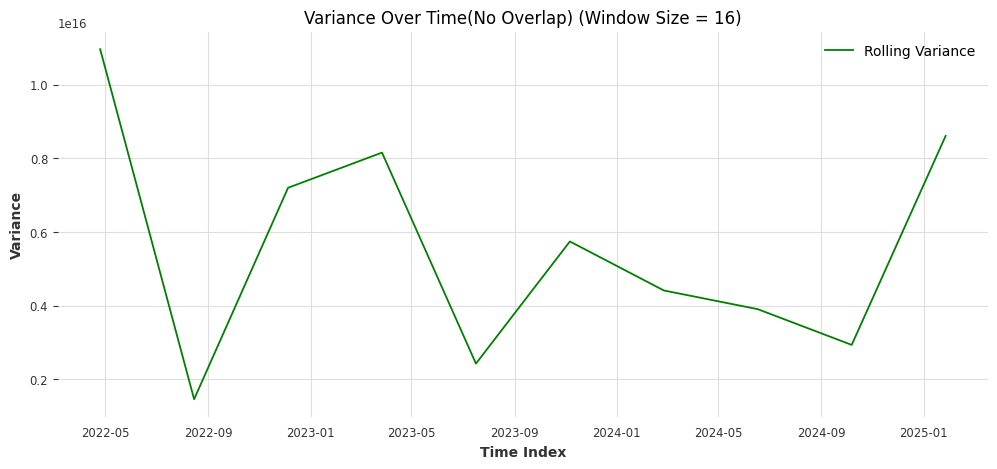

In [86]:
def variance(data):
    mean_value = mean(data)
    variance = sum((x - mean_value)**2 for x in data) / len(data)
    return variance
total_length =  len(energy_consumption_data)
variance_window_size = total_length // 10
print(variance_window_size)
def sliced_variances_calculator(data, time_index,variance_window_size):
    variances = []
    time_indices = []
    
    for i in range(0, len(data) - variance_window_size + 1, variance_window_size):  
        window_slice = data[i:i + variance_window_size]
        var = variance(window_slice)
        variances.append(var)
        time_indices.append(time_index[i + variance_window_size - 1]) 
    return variances, time_indices

variances, time_indices = sliced_variances_calculator(energy_consumption_data,time_index, variance_window_size)
print(variances, time_indices)
#Plotting the variances
plt.figure(figsize=(12, 5))
plt.plot(time_indices, variances, color='green', label='Rolling Variance')
plt.xlabel('Time Index')
plt.ylabel('Variance')
plt.title(f'Variance Over Time(No Overlap) (Window Size = {variance_window_size})')
plt.grid(True)
plt.legend()
plt.show()

## C. Autocorrelation Calculation

In [87]:
from statsmodels.tsa.stattools import acf
import numpy as np

autocorrelation function (ACF) at lag k, for k ≥ 0, of the time series is defined by
ro k = ck/ c0 where ck is the autocovariance at lag k

In [88]:
alpha = 0.05
confint = 1 - alpha
nlags = 160
def check_autocorrelation(data, nlags=10, alpha=0.05):
    data = np.asarray(data)
    acf_vals, _ = acf(data, nlags=nlags, alpha=alpha) 
    return acf_vals

acf_vals = check_autocorrelation(energy_consumption_data, nlags=nlags)
print(f"High Autocorrelation defined as {1 - alpha}")
for lag in range(1, 5):
    print(f"lag {lag:2d} → ACF = {acf_vals[lag]: .4f}")

High Autocorrelation defined as 0.95
lag  1 → ACF =  0.9028
lag  2 → ACF =  0.8092
lag  3 → ACF =  0.7166
lag  4 → ACF =  0.6537


Setting axis at 0

In [89]:
from darts import TimeSeries

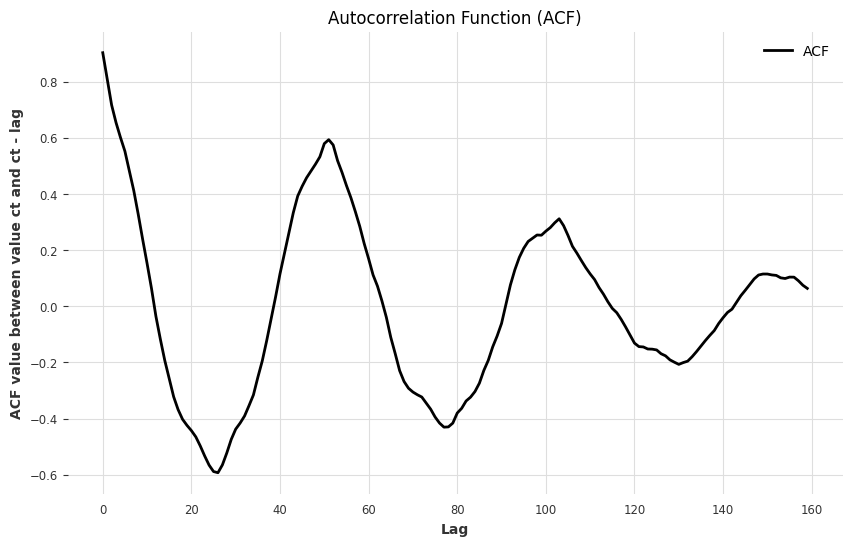

In [90]:
acf_series = TimeSeries.from_values(acf_vals[1:])
plt.figure(figsize=(10, 6))
acf_series.plot(label="ACF")
plt.title("Autocorrelation Function (ACF)")
plt.xlabel("Lag")
plt.ylabel("ACF value between value ct and ct - lag")
plt.legend(loc="upper right")
plt.show()

In [91]:
from darts.utils.statistics import (
    plot_acf,
)

## D. Differencing

Differencing is a simple approach to removing trends. No need to estimate parameters.

Dt = yt - y(t-1)

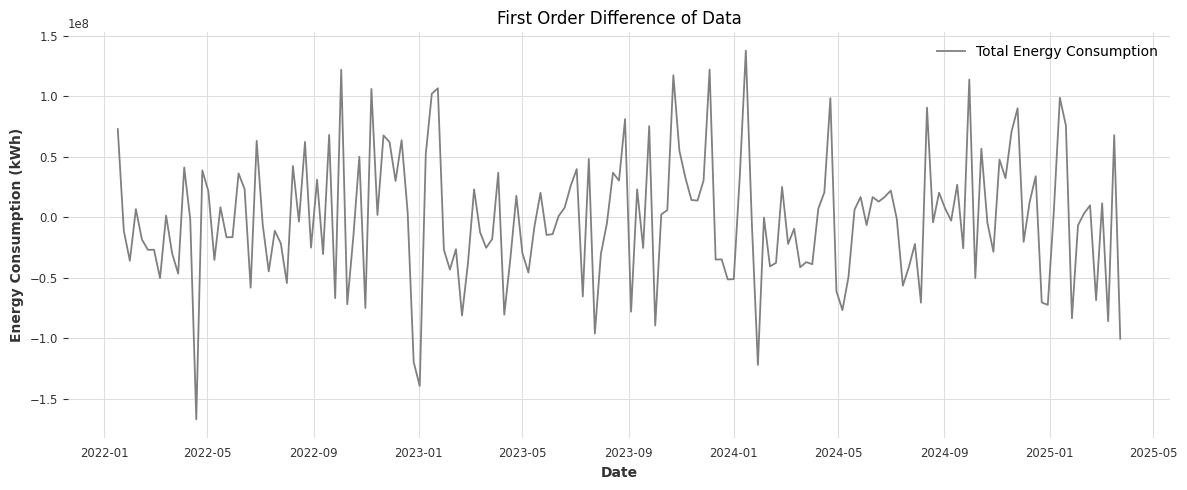

In [92]:
fig, ax = plt.subplots(figsize=(12, 5))
first_order_diff = df['Total Energy Consumption (kWh)'].diff()
ax.plot(first_order_diff, label='Total Energy Consumption', color='gray')
ax.set_title('First Order Diﬀerence of Data')
ax.set_xlabel('Date')
ax.set_ylabel('Energy Consumption (kWh)')
ax.legend()
ax.grid(True)
plt.tight_layout()
plt.show()

We can use differencing to remove seasonality, we can then plot its ACF, which will give us more insights for our model selection

In [93]:
from darts.utils.statistics import (
    stationarity_test_kpss,
    plot_acf)

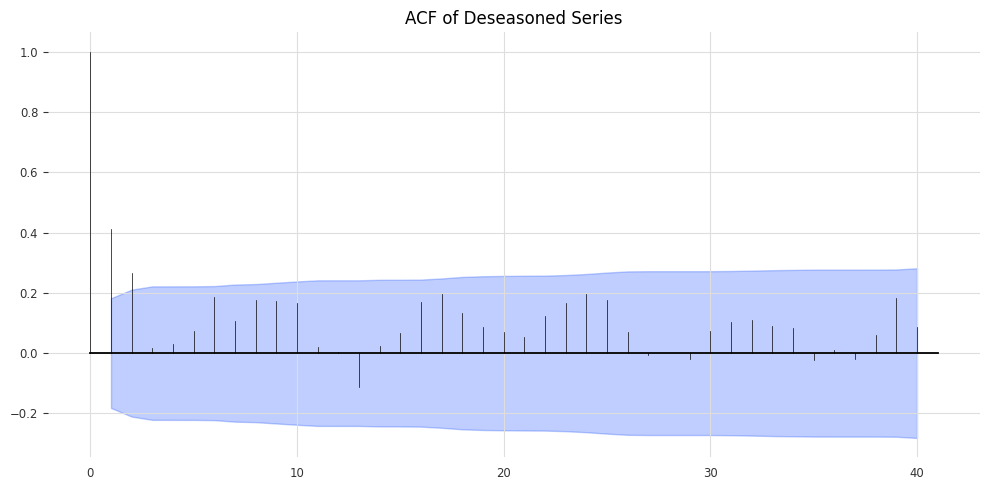

In [94]:
# --- Seasonal differencing (weekly seasonality, lag=52) ---
seasonal_diff = df['Total Energy Consumption (kWh)'].diff(52).dropna()

# --- Convert to Darts TimeSeries ---
seasonal_diff_series = TimeSeries.from_series(seasonal_diff)

# --- Plot ACF using Darts ---
plot_acf(seasonal_diff_series, max_lag=40)
plt.title("ACF of Deseasoned Series")
plt.tight_layout()
plt.show()

## E. Testing for stationnarity

In [95]:
from darts.utils.statistics import (
    stationarity_test_kpss,
    stationarity_tests)

In [96]:
initial_series = TimeSeries.from_values(energy_consumption_data)

In [97]:
alpha=0.05

In [98]:
is_stationary = stationarity_test_kpss(initial_series)
stat, p_value, lags, crit_vals = stationarity_test_kpss(initial_series)
print(f"KPSS statistic: {stat}")
print(f"p-value: {p_value}")
is_stationary = alpha <= p_value
print(f"Is stationary: {is_stationary}")

KPSS statistic: 0.11391747420474804
p-value: 0.1
Is stationary: True


In [99]:
is_stationary = stationarity_tests(
    initial_series,
    p_value_threshold_kpss=0.05
)

# Print interpretation
print("Series is stationary" if is_stationary else "Series is not stationary")


Series is stationary


## F. Periodogram and seasonality

There are many methods to test for white noise. One of which, documented in the Time Series Analysis book, is Cumulative Periodogram.


**Periodogram**

In [100]:
def compute_linear_periodogram(y):
    y = np.asarray(y)
    n = len(y)
    m = (n - 1) // 2 if n % 2 else n // 2
    freqs = np.arange(1, m + 1) / n
    I_vals = []

    for omega in freqs:
        cos_part = np.sum(y * np.cos(2 * np.pi * omega * np.arange(1, n + 1)))
        sin_part = np.sum(y * np.sin(2 * np.pi * omega * np.arange(1, n + 1)))
        I = (1 / n) * (cos_part**2 + sin_part**2)
        I_vals.append(I)

    return freqs, np.array(I_vals)


In [101]:
valid_mask = time_index.year <= 2024
series_trimmed = energy_consumption_data
series_trimmed = energy_consumption_data[valid_mask]

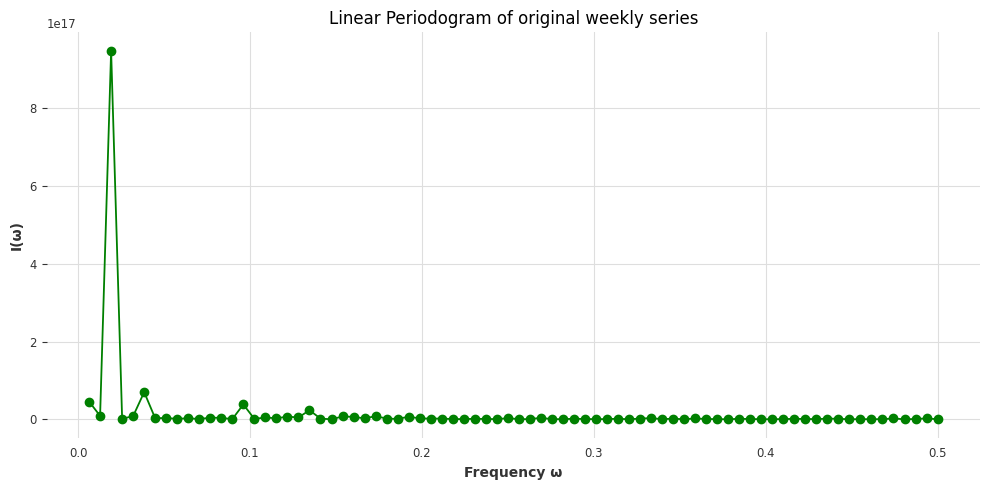

In [102]:
freqs_original, I_vals_original = compute_linear_periodogram(series_trimmed)
plt.figure(figsize=(10, 5))
plt.plot(freqs_original, I_vals_original, marker='o', color = 'g')
plt.title("Linear Periodogram of original weekly series")
plt.xlabel('Frequency ω')
plt.ylabel("I(ω)")
plt.grid(True)
plt.tight_layout()
plt.show()

In [103]:
threshold=2*1e16

In [104]:
significant_frequencies = [(w, I) for w, I in zip(freqs_original, I_vals_original) if I > threshold]
for freq, power in significant_frequencies:
    print(f"Frequency: {freq:.5f}, Power: {power:.2e}, Period ≈ {1/freq:.2f} weeks")

Frequency: 0.00641, Power: 4.57e+16, Period ≈ 156.00 weeks
Frequency: 0.01923, Power: 9.48e+17, Period ≈ 52.00 weeks
Frequency: 0.03846, Power: 6.99e+16, Period ≈ 26.00 weeks
Frequency: 0.09615, Power: 3.82e+16, Period ≈ 10.40 weeks
Frequency: 0.13462, Power: 2.34e+16, Period ≈ 7.43 weeks


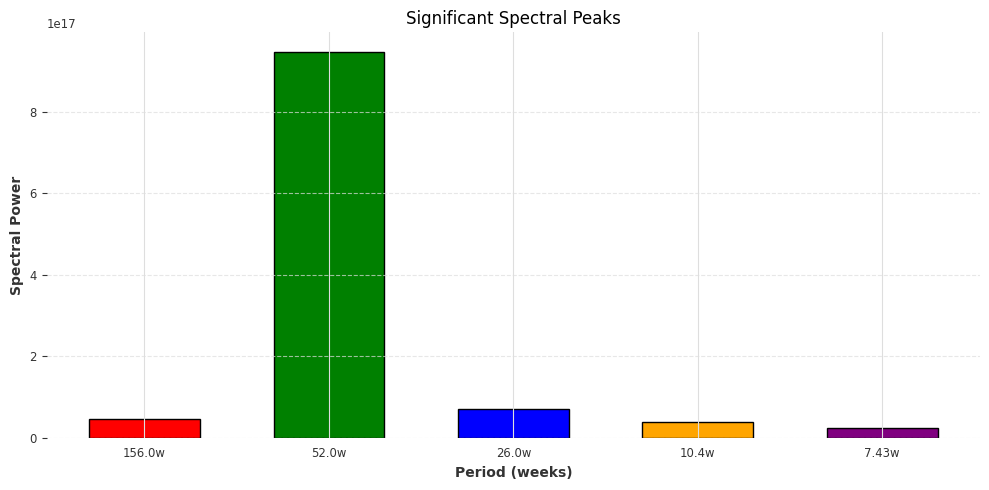

In [105]:

# Extract periods and powers
periods = [round(1 / freq, 2) for freq, _ in significant_frequencies]
powers = [power for _, power in significant_frequencies]

# Define colors for each bar
colors = ['red', 'green', 'blue', 'orange', 'purple']

# Create the bar plot
plt.figure(figsize=(10, 5))
bars = plt.bar(range(len(periods)), powers, color=colors, edgecolor='black', width=0.6)

# Add period labels on x-axis
plt.xticks(range(len(periods)), [f"{p}w" for p in periods])

# Labeling
plt.xlabel("Period (weeks)")
plt.ylabel("Spectral Power")
plt.title("Significant Spectral Peaks")
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()


In [106]:
threshold=2*1e16
significant_frequencies = [(w, I) for w, I in zip(freqs_original, I_vals_original) if I > threshold]
for freq, power in significant_frequencies:
    print(f"Frequency: {freq:.5f}, Power: {power:.2e}, Period ≈ {1/freq:.2f} weeks")

Frequency: 0.00641, Power: 4.57e+16, Period ≈ 156.00 weeks
Frequency: 0.01923, Power: 9.48e+17, Period ≈ 52.00 weeks
Frequency: 0.03846, Power: 6.99e+16, Period ≈ 26.00 weeks
Frequency: 0.09615, Power: 3.82e+16, Period ≈ 10.40 weeks
Frequency: 0.13462, Power: 2.34e+16, Period ≈ 7.43 weeks


Plotting one of the Fourrier Series

In [107]:
from matplotlib.cm import get_cmap

Plotting sine waves in separate subplots with different colors.

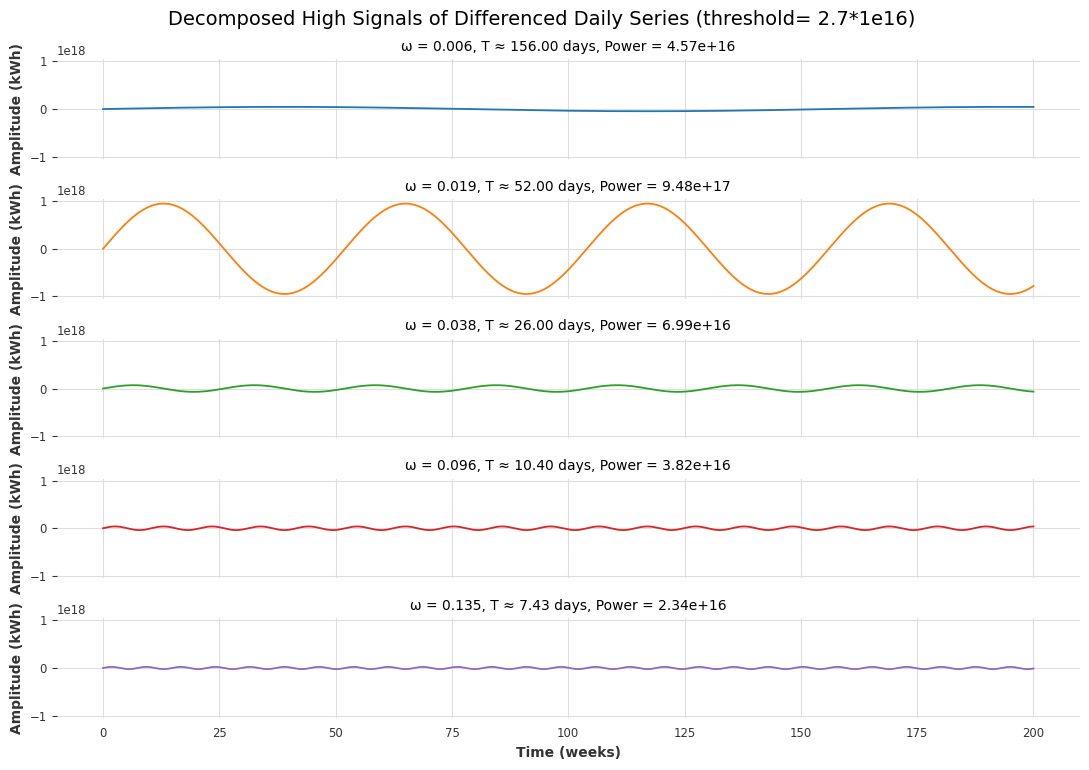

In [108]:
def plot_significant_waves(significant_freqs, duration=30, sampling_rate=100):
    t = np.linspace(0, duration, duration * sampling_rate)
    n = len(significant_freqs)
    cmap = get_cmap('tab10')

    max_amplitude = max(power for _, power in significant_freqs)

    fig, axs = plt.subplots(n, 1, figsize=(11, 1.5 * n), sharex=True)
    if n == 1:
        axs = [axs]

    for i, (freq, power) in enumerate(significant_freqs):
        amplitude = power
        y = amplitude * np.sin(2 * np.pi * freq * t)
        color = cmap(i % cmap.N)
        axs[i].plot(t, y, color=color)
        axs[i].set_ylim(-max_amplitude * 1.1, max_amplitude * 1.1)
        axs[i].set_title(f'ω = {freq:.3f}, T ≈ {1/freq:.2f} days, Power = {power:.2e}', fontsize=10)
        axs[i].set_ylabel('Amplitude (kWh)')
        axs[i].grid(True)

    axs[-1].set_xlabel('Time (weeks)')
    plt.tight_layout()
    fig.suptitle("Decomposed High Signals of Differenced Daily Series (threshold= 2.7*1e16) ", fontsize=14, y=1.02)
    plt.show()

threshold= 0.7*1e16
plot_significant_waves(significant_frequencies, duration=200, sampling_rate=300)

We conclude that our Time Series has a 52 week seasonality.

## G. Testing for White Noise

In [109]:
def plot_cumulative_periodogram(freqs, I_vals, show_plot=True, threshold=0.1):
    freqs = np.array(freqs)
    I_vals = np.array(I_vals)

    # Sort by frequency
    sorted_idx = np.argsort(freqs)
    freqs = freqs[sorted_idx]
    I_vals = I_vals[sorted_idx]

    # Keep only non-negative frequencies
    mask = freqs >= 0
    freqs = freqs[mask]
    I_vals = I_vals[mask]

    # Normalize and compute cumulative
    total_power = np.sum(I_vals)
    cumulative_power = np.cumsum(I_vals)
    C = cumulative_power / total_power

    # Expected under white noise: linear
    expected = np.linspace(0, 1, len(C))
    max_deviation = np.max(np.abs(C - expected))
    percent_error = max_deviation * 100
    is_white_noise = percent_error <= threshold * 100

    if show_plot:
        plt.figure(figsize=(10, 5))
        plt.step(freqs, C, where='post', label="Cumulative Periodogram", color='blue', lw=2)
        plt.plot([freqs[0], freqs[-1]], [0, 1], 'r--', label="KS Line: $y = x$")
        plt.xlabel("Frequency ω (1/week)")
        plt.ylabel("Cumulative Proportion of Power")
        plt.title("Cumulative Periodogram vs Flat Spectrum")
        plt.grid(True, linestyle='--', alpha=0.6)
        plt.ylim(0, 1.05)
        plt.legend()
        plt.tight_layout()
        plt.show()

        print(f"Maximum deviation from uniform: {percent_error:.2f}%")
        print("Conclusion:", "Likely white noise" if is_white_noise else "Not white noise")

    return freqs, C



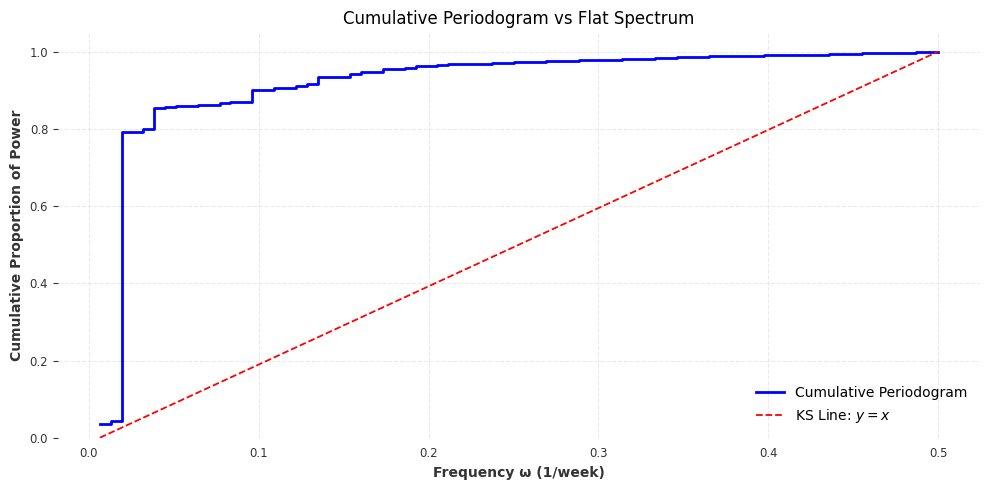

Maximum deviation from uniform: 78.97%
Conclusion: Not white noise


In [110]:
freqs_sorted, C_vals = plot_cumulative_periodogram(freqs_original, I_vals_original)

We conclude that our initial time series is not white noise.

# IV. Forecasting Models

In [111]:
import pandas as pd
from darts import TimeSeries
from darts.models import ARIMA
from darts.metrics import mape
import plotly.graph_objects as go
import plotly.io as pio
import warnings

## AR 1

AR1 8-week horizon

In [112]:
# Optional: suppress convergence warnings
warnings.filterwarnings("ignore")

# Ensure consistent lengths
min_len = min(len(time_index), len(energy_consumption_data))
time_index = time_index[:min_len]
energy_consumption_data = energy_consumption_data[:min_len]

# --- Convert to Darts TimeSeries (WEEKLY) ---
series = TimeSeries.from_times_and_values(
    pd.DatetimeIndex(time_index),
    energy_consumption_data,
    fill_missing_dates=True,
)

# --- Fit ARIMA and Multi-Step Forecast (Horizon = 8 weeks) ---
model = ARIMA(1, 0, 0)
horizon = 8
start = len(series) - 52 - horizon + 1

forecast = model.historical_forecasts(
    series=series,
    start=start,
    forecast_horizon=horizon,
    stride=1,
    retrain=True,
    train_length=104,
    last_points_only=True,
    show_warnings=False  # Optional: suppress warning messages
)
# --- Align actual values ---
actual = series.slice(forecast.start_time(), forecast.end_time())

# Convert to Pandas
actual_df = actual.to_series().to_frame(name="Actual")
forecast_df = forecast.to_series().to_frame(name="Forecast")

# --- Plot with Plotly ---
fig = go.Figure()

# Actual values
fig.add_trace(go.Scatter(
    x=actual_df.index,
    y=actual_df["Actual"],
    mode='lines+markers',
    name='Actual Weekly',
    line=dict(color='blue')
))

# Forecast values
fig.add_trace(go.Scatter(
    x=forecast_df.index,
    y=forecast_df["Forecast"],
    mode='lines+markers',
    name='Rolling Forecasted Weekly (AR(1,0,0), 8-week horizon)',
    line=dict(color='red')
))

# Layout
fig.update_layout(
    title="AR(1,0,0) Rolling Forecast (8-week Horizon, Weekly)",
    xaxis_title="Date",
    yaxis_title="Energy Consumption (kWh)",
    legend=dict(x=0, y=1),
    template="plotly_dark",
    width=1000,
    height=500
)

# Show plot
fig.show()

# --- Save JSON for Next.js ---
pio.write_json(
    fig,
    "/Users/omarabdesslem/Documents/Projects/Thesis-Website/public/AR/AR_data.json",
    pretty=True
)

# --- Evaluate and save MAPE ---
if len(actual) == len(forecast):
    mape_score = mape(actual, forecast)
    print(f"MAPE (Weekly, 8-week Horizon): {mape_score:.2f}%")

    with open("/Users/omarabdesslem/Documents/Projects/Thesis-Website/public/AR/ar_mape.txt", "w") as f:
        f.write(f"{mape_score:.2f}")
else:
    print("Forecast and actual series do not match in length.")



MAPE (Weekly, 8-week Horizon): 8.39%


## ARMA

ARMA 8-week horizon

In [113]:
warnings.filterwarnings("ignore")
# Ensure consistent lengths
min_len = min(len(time_index), len(energy_consumption_data))
time_index = time_index[:min_len]
energy_consumption_data = energy_consumption_data[:min_len]

# --- Convert to Darts TimeSeries (WEEKLY) ---
series = TimeSeries.from_times_and_values(
    pd.DatetimeIndex(time_index),
    energy_consumption_data,
    fill_missing_dates=True,
)

# --- Training and prediction settings ---
horizon = 8                    # forecast 12 steps ahead
train_len = 104                # 2 years of training
start_idx = len(series) - 52  # last 1 year

# --- Containers for predicted and actual values ---
predicted = []
actual_vals = []

# --- Initialize model ---
model = ARIMA(1, 0, 1)  # ARIMA(1,0,0) with yearly seasonality
horizon = 8            
start = len(series) - 52 - horizon + 1

forecast = model.historical_forecasts(
    series=series,
    start=start,
    forecast_horizon=horizon,
    stride=1,
    retrain=True,
    train_length=104,
    last_points_only=True,
    show_warnings=False  # Optional: suppress warning messages
)
# --- Align actual values ---
actual = series.slice(forecast.start_time(), forecast.end_time())

# Convert to Pandas
actual_df = actual.to_series().to_frame(name="Actual")
forecast_df = forecast.to_series().to_frame(name="Forecast")

fig = go.Figure()

# Actual values
fig.add_trace(go.Scatter(
    x=actual_df.index,
    y=actual_df["Actual"],
    mode='lines+markers',
    name='Actual Weekly',
    line=dict(color='blue')
))

# --- Plot ---
fig = go.Figure()

fig.add_trace(go.Scatter(
    x=actual_df.index,
    y=actual_df["Actual"],
    mode='lines+markers',
    name='Actual Weekly',
    line=dict(color='blue')
))

fig.add_trace(go.Scatter(
    x=forecast_df.index,
    y=forecast_df["Forecast"],
    mode='lines+markers',
    name=' Autoregressive Moving Average Model (1,0,1)',
    line=dict(color='red')
))

fig.update_layout(
    title="Autoregressive Moving Average Model (1,0,1), 8-Week Horizon)",
    xaxis_title="Date",
    yaxis_title="Energy Consumption (kWh)",
    legend=dict(x=0, y=1),
    template="plotly_dark",
    width=1000,
    height=500
)

fig.show()

# --- Save ---
pio.write_json(
    fig,
    "/Users/omarabdesslem/Documents/Projects/Thesis-Website/public/ARMA/ARMA_data.json",
    pretty=True
)

# --- MAPE ---
if len(actual) == len(forecast):
    mape_score = mape(actual, forecast)
    print(f"MAPE (Student Forcing, Weekly): {mape_score:.2f}%")

    with open("/Users/omarabdesslem/Documents/Projects/Thesis-Website/public/ARMA/arma_mape.txt", "w") as f:
        f.write(f"{mape_score:.2f}")
else:
    print("Forecast and actual series do not match in length.")


MAPE (Student Forcing, Weekly): 8.48%


## ARIMA

In [114]:
# Ensure consistent lengths
min_len = min(len(time_index), len(energy_consumption_data))
time_index = time_index[:min_len]
energy_consumption_data = energy_consumption_data[:min_len]

# --- Convert to Darts TimeSeries (WEEKLY) ---
series = TimeSeries.from_times_and_values(
    pd.DatetimeIndex(time_index),
    energy_consumption_data,
    fill_missing_dates=True,
)

model = ARIMA(1, 1, 0)  # ARIMA(1,1,0) with yearly seasonality
horizon = 8            
start = len(series) - 52 - horizon + 1

forecast = model.historical_forecasts(
    series=series,
    start=start,
    forecast_horizon=horizon,
    stride=1,
    retrain=True,
    train_length=104,
    last_points_only=True,
    show_warnings=False  # Optional: suppress warning messages
)

# --- Align actual values ---
actual = series.slice(forecast.start_time(), forecast.end_time())

# Convert to Pandas
actual_df = actual.to_series().to_frame(name="Actual")
forecast_df = forecast.to_series().to_frame(name="Forecast")

fig = go.Figure()

# Actual values
fig.add_trace(go.Scatter(
    x=actual_df.index,
    y=actual_df["Actual"],
    mode='lines+markers',
    name='Actual Weekly',
    line=dict(color='blue')
))

# Forecast values
fig.add_trace(go.Scatter(
    x=forecast_df.index,
    y=forecast_df["Forecast"],
    mode='lines+markers',
    name='Autoregressive Integrated Moving Average Model(1,1,0), 8-week horizon)',
    line=dict(color='red')
))

# Layout
fig.update_layout(
    title="Autoregressive Integrated Moving Average Model(1,1,0), 8-week horizon)",
    xaxis_title="Date",
    yaxis_title="Energy Consumption (kWh)",
    legend=dict(x=0, y=1),
    template="plotly_dark",
    width=1000,
    height=500
)

# Show plot
fig.show()

# --- Save JSON for Next.js ---
pio.write_json(
    fig,
    "/Users/omarabdesslem/Documents/Projects/Thesis-Website/public/ARIMA/ARIMA_data.json",
    pretty=True
)

# --- Evaluate and save MAPE ---
if len(actual) == len(forecast):
    mape_score = mape(actual, forecast)
    print(f"MAPE (Weekly, 8-week Horizon): {mape_score:.2f}%")

    with open("/Users/omarabdesslem/Documents/Projects/Thesis-Website/public/ARIMA/arima_mape.txt", "w") as f:
        f.write(f"{mape_score:.2f}")
else:
    print("Forecast and actual series do not match in length.")


MAPE (Weekly, 8-week Horizon): 8.42%


## SARIMA

8 week horizon

In [115]:
# Ensure consistent lengths
min_len = min(len(time_index), len(energy_consumption_data))
time_index = time_index[:min_len]
energy_consumption_data = energy_consumption_data[:min_len]

# --- Convert to Darts TimeSeries (WEEKLY) ---
series = TimeSeries.from_times_and_values(
    pd.DatetimeIndex(time_index),
    energy_consumption_data,
    fill_missing_dates=True,
)
#model = SARIMAX(energy_consumption_data, order=(2, 1, 0), seasonal_order=(1, 1, 1, 52))
# --- Fit ARIMA and Multi-Step Forecast (Horizon = 8 weeks) ---
model = ARIMA(1, 0, 0, seasonal_order=(1,0,0,52))  # ARIMA(1,0,1) with yearly seasonality
horizon = 8             # forecast 8 steps ahead
forecast = model.historical_forecasts(
    series=series,
    start=len(series) - 52,  # start 1 year before end
    forecast_horizon=horizon,
    stride=1,
    retrain=True,
    train_length=104,        # train on 2 years
    last_points_only=True    # return only the final forecast point
)

# --- Align actual values ---
actual = series.slice(forecast.start_time(), forecast.end_time())

# Convert to Pandas
actual_df = actual.to_series().to_frame(name="Actual")
forecast_df = forecast.to_series().to_frame(name="Forecast")

# --- Plot with Plotly ---
fig = go.Figure()

# Actual values
fig.add_trace(go.Scatter(
    x=actual_df.index,
    y=actual_df["Actual"],
    mode='lines+markers',
    name='Actual Weekly',
    line=dict(color='blue')
))

# Forecast values
fig.add_trace(go.Scatter(
    x=forecast_df.index,
    y=forecast_df["Forecast"],
    mode='lines+markers',
    name='Seasonal Autoregressive Integrated Moving Average(1,0,0), (1,0,0)[52]-52-week seasonality, 8-week horizon)',
    line=dict(color='red')
))

# Layout
fig.update_layout(
    title="Seasonal Autoregressive Integrated Moving Average(1,0,0), (1,0,0)[52]-52-week seasonality, 8-week horizon)",
    xaxis_title="Date",
    yaxis_title="Energy Consumption (kWh)",
    legend=dict(x=0, y=1),
    template="plotly_dark",
    width=1000,
    height=500
)

# Show plot
fig.show()

# --- Save JSON for Next.js ---
pio.write_json(
    fig,
    "/Users/omarabdesslem/Documents/Projects/Thesis-Website/public/SARIMA/SARIMA_data.json",
    pretty=True
)

# --- Evaluate and save MAPE ---
if len(actual) == len(forecast):
    mape_score = mape(actual, forecast)
    print(f"MAPE (Weekly, 8-week Horizon): {mape_score:.2f}%")

    with open("/Users/omarabdesslem/Documents/Projects/Thesis-Website/public/SARIMA/sarima_mape.txt", "w") as f:
        f.write(f"{mape_score:.2f}")
else:
    print("Forecast and actual series do not match in length.")


MAPE (Weekly, 8-week Horizon): 6.60%


## SARIMAX

Seasonal ARIMA with eXogenous variables forecasts time series data that shows trends, seasonality, and is affected by external variables.

In our setup:
- Non-seasonal order: $(1, 0, 0)$
- Seasonal order: $(1, 0, 0, 52)$
- Exogenous input: weekly temperature values

The model looks like:

$y_t = c + \phi_1 y_{t-1} + \Phi_1 y_{t-52} + \beta X_t + \varepsilon_t$

Where:
- $y_t$ is the value at time $t$ (energy consumption)
- $\phi_1$ is the non-seasonal autoregressive term
- $\Phi_1$ is the seasonal autoregressive term (lag of 52 weeks)
- $\theta_1$ is the moving average term
- $\varepsilon_t$ is the error (white noise)
- $X_t$ is the exogenous variable (weekly temperature)

In [116]:
# --- Step 1: Preprocessing and Alignment ---
weekly_temp = weekly_temp.dropna()

# Ensure same length
min_len = min(len(time_index), len(energy_consumption_data), len(weekly_temp))
time_index = time_index[:min_len]
energy_consumption_data = energy_consumption_data[:min_len]
weekly_temp = weekly_temp[:min_len]

# Create TimeSeries objects
series = TimeSeries.from_times_and_values(
    pd.DatetimeIndex(time_index),
    energy_consumption_data,
    fill_missing_dates=True,
)

weekly_temp.index = pd.DatetimeIndex(weekly_temp.index)
temp_cov = TimeSeries.from_series(weekly_temp)

# Slice to common intersection
series = series.slice_intersect(temp_cov)
temp_cov = temp_cov.slice_intersect(series)

# --- Step 2: SARIMAX Model with Exogenous Temp (Weekly Temp) ---
model = ARIMA(1, 0, 0, seasonal_order=(1, 0, 0, 52))

# Rolling 8-week forecasts across the last 52 weeks
forecast_list = model.historical_forecasts(
    series=series,
    future_covariates=temp_cov,
    start=len(series) - 52,
    forecast_horizon=8,
    stride=1,
    retrain=True,
    train_length=104,
    last_points_only=True,
    show_warnings=False
)

# --- Step 3: Combine forecasts ---
forecast = forecast_list[0]
for f in forecast_list[1:]:
    forecast = forecast.append(f)

# Match actuals
actual = series.slice(forecast.start_time(), forecast.end_time())

# --- Step 4: Plot ---
actual_df = actual.to_series().to_frame(name="Actual")
forecast_df = forecast.to_series().to_frame(name="Forecast")

fig = go.Figure()
fig.add_trace(go.Scatter(
    x=actual_df.index,
    y=actual_df["Actual"],
    mode='lines+markers',
    name='Actual Weekly',
    line=dict(color='blue')
))
fig.add_trace(go.Scatter(
    x=forecast_df.index,
    y=forecast_df["Forecast"],
    mode='lines+markers',
    name='Seasonal Autoregressive Integrated Moving Average with eXogenous variables Forecast (8w Horizon)',
    line=dict(color='red')
))

fig.update_layout(
    title="SARIMAX(1,0,0)(1,0,0,52) + Weekly Temp | 8-Week Horizon",
    xaxis_title="Date",
    yaxis_title="Energy Consumption (kWh)",
    legend=dict(x=0, y=1),
    template="plotly_dark",
    width=1000,
    height=500
)
fig.show()

# --- Step 5: Save Results ---
pio.write_json(
    fig,
    "/Users/omarabdesslem/Documents/Projects/Thesis-Website/public/SARIMAX/SARIMAX_data.json",
    pretty=True
)

# --- Step 6: MAPE ---
if len(actual) == len(forecast):
    mape_score = mape(actual, forecast)
    print(f"MAPE (SARIMAX, Rolling 8-week Forecasts): {mape_score:.2f}%")

    with open("/Users/omarabdesslem/Documents/Projects/Thesis-Website/public/SARIMAX/sarimax_mape.txt", "w") as f:
        f.write(f"{mape_score:.2f}")
else:
    print("Forecast and actual series do not match in length.")


MAPE (SARIMAX, Rolling 8-week Forecasts): 4.83%


# V. White Noise test of Residuals

## Cumulative Periodogram of SARIMA

SARIMA(1,0,0,(1,0,0,[52])) Cumulative Periodogram

Max deviation (KS statistic): 12.89%


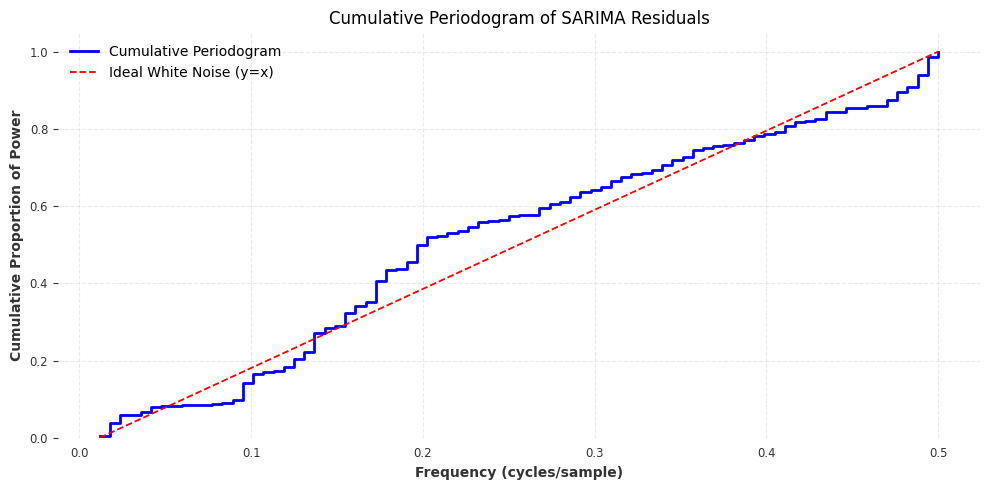

In [117]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import periodogram
from statsmodels.tsa.statespace.sarimax import SARIMAX

# --- Fit SARIMA model ---
model = SARIMAX(energy_consumption_data, order=(1, 0, 0))
results = model.fit(disp=False)

# --- Get residuals  ---
residuals = results.resid

# --- Periodogram with Hann window ---
freqs, power = periodogram(residuals, window='hann')

# --- Remove near-zero frequencies ---
min_freq = 1 / len(residuals)
mask = freqs > min_freq
freqs = freqs[mask]
power = power[mask]

# --- Cumulative periodogram ---
cumulative_power = np.cumsum(power) / np.sum(power)
expected = np.linspace(0, 1, len(cumulative_power))

# --- KS statistic (max deviation from ideal)
ks_stat = np.max(np.abs(cumulative_power - expected))
print(f"Max deviation (KS statistic): {ks_stat*100:.2f}%")

# --- Plot cumulative periodogram ---
plt.figure(figsize=(10, 5))
plt.step(freqs, cumulative_power, where='post', label="Cumulative Periodogram", color='blue', lw=2)
plt.plot([freqs[0], freqs[-1]], [0, 1], 'r--', label="Ideal White Noise (y=x)")
plt.xlabel("Frequency (cycles/sample)")
plt.ylabel("Cumulative Proportion of Power")
plt.title("Cumulative Periodogram of SARIMA Residuals")
plt.grid(True, linestyle='--', alpha=0.6)
plt.ylim(0, 1.05)
plt.legend()
plt.tight_layout()
plt.show()


## KS results on training data

Fitting model: ARIMA(1,0,0)
ARIMA(1,0,0): KS = 12.89%
Fitting model: ARIMA(1,1,0)
ARIMA(1,1,0): KS = 10.87%
Fitting model: ARIMA(1,0,1)
ARIMA(1,0,1): KS = 15.91%
Fitting model: SARIMA(1,0,0)(1,0,0,52)
SARIMA(1,0,0)(1,0,0,52): KS = 12.11%
Fitting model: SARIMAX(1,0,0)(1,0,0,52) + Temp
SARIMAX(1,0,0)(1,0,0,52) + Temp: KS = 10.47%


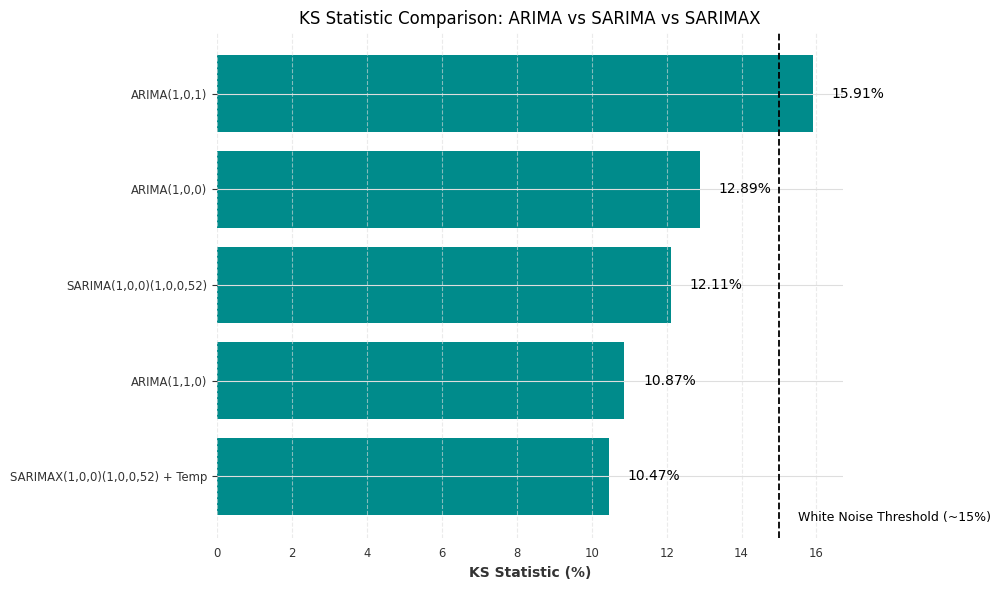

In [118]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import periodogram
from statsmodels.tsa.statespace.sarimax import SARIMAX

# --- Define only the desired models ---
model_configs = {
    "ARIMA(1,0,0)": ((1, 0, 0), (0, 0, 0, 0)),
    "ARIMA(1,1,0)": ((1, 1, 0), (0, 0, 0, 0)),
    "ARIMA(1,0,1)": ((1, 0, 1), (0, 0, 0, 0)),
    "SARIMA(1,0,0)(1,0,0,52)": ((1, 0, 0), (1, 0, 0, 52)),
    "SARIMAX(1,0,0)(1,0,0,52) + Temp": ((1, 0, 0), (1, 0, 0, 52)),
}

ks_results = {}

# --- Loop through each model ---
for label, (order, seasonal_order) in model_configs.items():
    print(f"Fitting model: {label}")
    
    if "Temp" in label:
        model = SARIMAX(energy_consumption_data, exog=weekly_temp, order=order, seasonal_order=seasonal_order)
    else:
        model = SARIMAX(energy_consumption_data, order=order, seasonal_order=seasonal_order)
    
    results = model.fit(disp=False)
    residuals = results.resid

    if len(residuals) < 60:
        print(f"Skipping {label}: too few residuals.")
        continue

    freqs, power = periodogram(residuals, window='hann')
    min_freq = 1 / len(residuals)
    mask = freqs > min_freq
    freqs = freqs[mask]
    power = power[mask]

    cumulative_power = np.cumsum(power) / np.sum(power)
    expected = np.linspace(0, 1, len(cumulative_power))
    ks_stat = np.max(np.abs(cumulative_power - expected))

    ks_results[label] = ks_stat * 100
    print(f"{label}: KS = {ks_stat*100:.2f}%")

# --- Bar chart of KS stats ---
sorted_items = sorted(ks_results.items(), key=lambda x: x[1])
labels = [k for k, _ in sorted_items]
ks_values = [v for _, v in sorted_items]

plt.figure(figsize=(10, 6))
bars = plt.barh(labels, ks_values, color='darkcyan')

for bar in bars:
    width = bar.get_width()
    plt.text(width + 0.5, bar.get_y() + bar.get_height() / 2,
             f"{width:.2f}%", va='center', fontsize=10)

plt.xlabel("KS Statistic (%)")
plt.axvline(15, color='black', linestyle='--')
plt.text(15.5, -0.5, 'White Noise Threshold (~15%)', ha='left', va='bottom', fontsize=9)

plt.title("KS Statistic Comparison: ARIMA vs SARIMA vs SARIMAX")
plt.grid(axis='x', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()


We conclude that AR(1), ARIMA(1,1,0), SARIMA(1,0,0,(1,0,0[52])), and SARIMAX(1,0,0,(1,0,0[52]) with Temp as Future Cov.) produce white noise residuals when tested on the full training data. They might be suitable models.

We can hyptothesize that the SARIMAX model might be the best fit model based on how the white noise residuals score is lowest.

# VI. Evaluation

In [119]:
from darts.metrics import mape

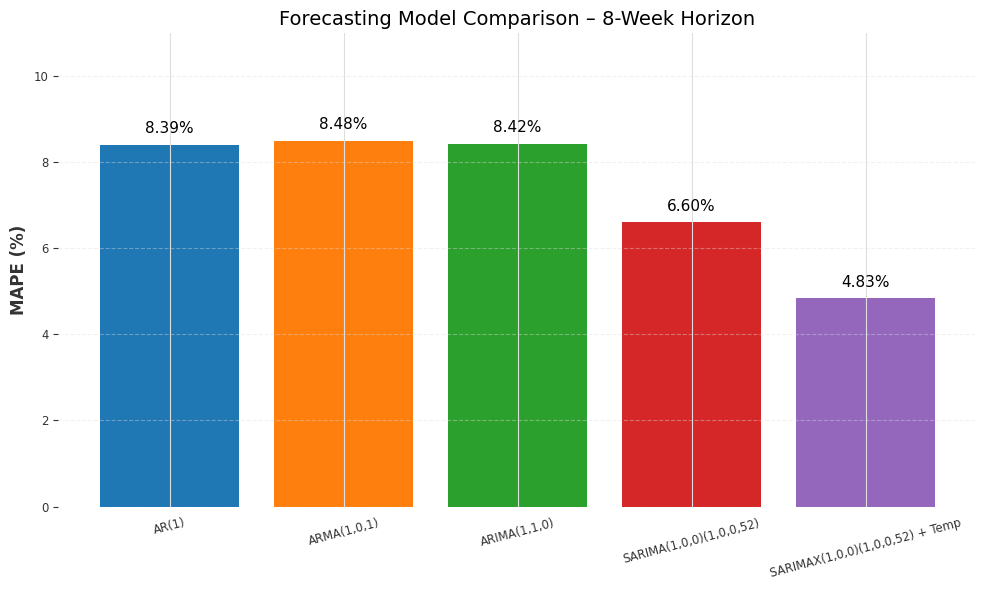

In [120]:
# Define models in desired order
models = {
    "AR(1)": "/Users/omarabdesslem/Documents/Projects/Thesis-Website/public/AR/ar_mape.txt",
    "ARMA(1,0,1)": "/Users/omarabdesslem/Documents/Projects/Thesis-Website/public/ARMA/arma_mape.txt",
    "ARIMA(1,1,0)": "/Users/omarabdesslem/Documents/Projects/Thesis-Website/public/ARIMA/arima_mape.txt",
    "SARIMA(1,0,0)(1,0,0,52)": "/Users/omarabdesslem/Documents/Projects/Thesis-Website/public/SARIMA/sarima_mape.txt",
    "SARIMAX(1,0,0)(1,0,0,52) + Temp": "/Users/omarabdesslem/Documents/Projects/Thesis-Website/public/SARIMAX/sarimax_mape.txt",
}

# Read MAPE values
mape_scores = {}
for model_name, path in models.items():
    try:
        with open(path, "r") as f:
            mape_scores[model_name] = float(f.read().strip())
    except Exception as e:
        mape_scores[model_name] = None
        print(f"⚠️ Could not read MAPE for {model_name}: {e}")

# Filter out any models with missing values
mape_scores = {k: v for k, v in mape_scores.items() if v is not None}

# Create DataFrame in order
df = pd.DataFrame({
    "Model": list(mape_scores.keys()),
    "MAPE": list(mape_scores.values())
})

# Plot settings
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd']

plt.figure(figsize=(10, 6))
bars = plt.bar(df["Model"], df["MAPE"], color=colors[:len(df)])

# Annotate bars with MAPE %
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, height + 0.2,
             f"{height:.2f}%", ha='center', va='bottom', fontsize=11)

plt.ylabel("MAPE (%)", fontsize=12)
plt.title("Forecasting Model Comparison – 8-Week Horizon", fontsize=14)
plt.xticks(rotation=15)
plt.ylim(0, max(df["MAPE"]) + 2.5)
plt.grid(axis='y', linestyle='--', alpha=0.4)
plt.tight_layout()
plt.show()
